# Manual Labeling Data Preparation

In [1]:
import rasterio
import random
import matplotlib.pyplot as plt
import os
import sys
import datetime
from sklearn.utils import class_weight
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
module_path = os.path.abspath(os.path.join('rcnn'))
if module_path not in sys.path:
    sys.path.append(module_path)

import utilities as util
import importlib
import rnn_tiles
import rnn_pixels
import numpy as np

import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

In [18]:
importlib.reload(rnn_pixels)
importlib.reload(rnn_tiles)
importlib.reload(util)

<module 'utilities' from '/host/Code/florence_mapping/utilities.py'>

Load in the training data

In [2]:
lc_labels = rasterio.open('/deep_data/recurrent_data/NLCD_DATA/landcover/NLCD_2011_Land_Cover_L48_20190424.img')
canopy_labels = rasterio.open('/deep_data/recurrent_data/NLCD_DATA/canopy/CONUSCartographic_2_8_16/Cartographic/nlcd2011_usfs_conus_canopy_cartographic.img')

### Ingest the landsat imagery stacked into yearly seasonal tiles

We don't really need to do this here but the code is just copied from the rcnn code

In [3]:
tiles = {}
landsat_datasets = {}
tiles['028012'] = ['20110324', '20110612', '20110831', '20111103']
tiles['029011'] = ['20110308', '20110425', '20110831', '20111103']
tiles['028011'] = ['20110308', '20110628', '20110831', '20111103']
for tile_number, dates in tiles.items():
    tile_datasets = []
    l8_image_paths = []
    for date in dates:
        l8_image_paths.append('/deep_data/recurrent_data/tile{}/combined/combined{}.tif'.format(tile_number, date))
    for fp in l8_image_paths:
        tile_datasets.append(rasterio.open(fp))
    landsat_datasets[tile_number] = tile_datasets

In [5]:
tile_size = 9
tile_list = ['028012', '029011', '028011']
class_dict = util.indexed_dictionary
#px = rnn_pixels.make_pixels(tile_size, tile_list)

In [19]:
#clean_px = rnn_pixels.make_clean_pix(tile_list, tile_size, landsat_datasets,lc_labels, canopy_labels, 100, buffer_pix=1)

### Testing for Runtime and Memory Usage

In [55]:
%load_ext line_profiler

In [57]:
%lprun -f rnn_pixels.tvt_pix_locations rnn_pixels.tvt_pix_locations(landsat_datasets, lc_labels, canopy_labels, tile_size, tile_list, clean_pixels, 10, 10, 10, class_dict)

Beginning TVT pixel creation.
Iterating through data and clipping for balance.

Processing Complete.


In [67]:
w_tile_gen = rnn_tiles.rnn_tile_gen(landsat_datasets, lc_labels, canopy_labels, tile_size, class_count)
w_generator = w_tile_gen.tile_generator(clean_pixels, batch_size=1, flatten=True, canopy=True)

In [73]:
%lprun -f w_tile_gen.tile_generator w_tile_gen.tile_generator(clean_pixels[:2], batch_size=1, flatten=True, canopy=True)

In [74]:
%timeit w_tile_gen.tile_generator(clean_pixels[:2], batch_size=1, flatten=True, canopy=True)

6.15 ms ± 111 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
# effectively make_clean_pix

### Generate Data for TVT

In [6]:
px = rnn_pixels.make_pixels(1, tile_list)

In [9]:
len(px)

75000000

In [7]:
tile_size = 5
print(datetime.datetime.now())
px_to_use1 = px[:1000]
clean_pixels1 = rnn_pixels.delete_bad_tiles(landsat_datasets,lc_labels, canopy_labels, px_to_use1, tile_size, buffer_pix=1)
print(datetime.datetime.now())
print(len(clean_pixels1))

2019-11-30 00:52:58.994537
2019-11-30 00:53:02.030771
341


In [34]:
tile_size = 1
print(datetime.datetime.now())
tvt_pixels2 = rnn_pixels.tvt_pix_locations(landsat_datasets, lc_labels, 
    canopy_labels, tile_size, tile_list, clean_pixels1, 150, 150, 1000, class_dict)
print(datetime.datetime.now())
print(len(tvt_pixels2[0]), len(tvt_pixels2[1]), len(tvt_pixels2[2]))

2019-12-02 18:26:55.950124
Beginning TVT pixel creation.
Iterating through data and clipping for balance.

Processing Complete.
2019-12-02 18:26:58.093211
0 15 150


#### See if Data is Actually Balanced

In [258]:
class_count = 6

pixels = tvt_pixels[2]

# gets balanced pixels locations 
w_tile_gen = rnn_tiles.rnn_tile_gen(landsat_datasets, lc_labels, canopy_labels, tile_size, class_count)
w_generator = w_tile_gen.tile_generator(pixels, batch_size=1, flatten=True, canopy=True)
total_labels = list()
count = 0
#buckets = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[]}
buckets = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[]}

while count < len(pixels):
        image_b, label_b = next(w_generator)
        #print(image_b['tile_input'].shape)
        buckets[np.argmax(label_b["landcover"])].append({
            "pixel_loc" : pixels[count][0],
            "tile_name" : pixels[count][1],
            "landcover" : np.argmax(label_b["landcover"]),
            "canopy" : float(label_b["canopy"])
                                }) # appends pixels to dictionary
        count+=1
count = 0 
for z, j in buckets.items():
    print(z, len(j))
    count += len(j)
print(count) 

0 125
1 0
2 139
3 64
4 0
5 5
333


run through the pixels, buffer each pixel and add it to a geopandas dataset, convert that CRS to 4326 then save that geopandas dataset as a shapefile 

In [199]:
#count_per_class = 3000
count_per_class = 1500 # 1667 * 6 ~= 10,000
pixel_coords = []

for lc_class in buckets.keys():
    for i, pixel in enumerate(buckets[lc_class]):
        landsat_ds = landsat_datasets[pixel["tile_name"]][0] # get the stack of ls datasets from that location and take the first
        x, y = landsat_ds.xy(pixel["pixel_loc"][0], pixel["pixel_loc"][1])
        pixel_coords.append({
        "x" : x,
        "y" : y,
        "label" : pixel["landcover"],
        "canopy" : pixel["canopy"],
        "tile_name" : pixel["tile_name"]
                        })
        if i > count_per_class:
            break

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff7eebf8198>]],
      dtype=object)

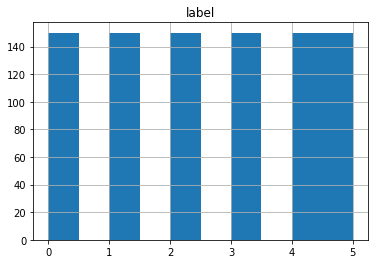

In [200]:
# create a dataframe from the pixel coordinates
df = pd.DataFrame(pixel_coords)
df.hist(column="label")

In [201]:
landsat_datasets["029011"][0].crs

CRS.from_wkt('PROJCS["Albers",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378140,298.2569999999957,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]')

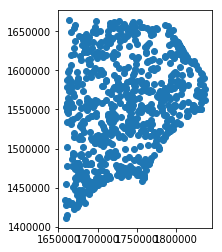

In [202]:
gdf = gpd.GeoDataFrame(df, geometry = gpd.points_from_xy(df.x, df.y), crs=landsat_datasets["028011"][0].crs)
gdf.plot()

In [203]:
# buffer by 15 meters to make 30x30 pixel
buffer = gdf.buffer(15)

envelope = buffer.envelope  
gdf.geometry = envelope
gdf.head()

,canopy,label,tile_name,x,y,geometry
0,0.0,0,028011,1750110.0,1529580.0,"POLYGON ((1750095 1529565, 1750125 1529565, 17..."
1,0.0,0,029011,1811340.0,1612260.0,"POLYGON ((1811325 1612245, 1811355 1612245, 18..."
2,0.0,0,028012,1729920.0,1463220.0,"POLYGON ((1729905 1463205, 1729935 1463205, 17..."
3,0.0,0,029011,1792140.0,1563300.0,"POLYGON ((1792125 1563285, 1792155 1563285, 17..."
4,0.0,0,028011,1740000.0,1549830.0,"POLYGON ((1739985 1549815, 1740015 1549815, 17..."


In [204]:
gdf = gdf.to_crs("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")
gdf.head()

,canopy,label,tile_name,x,y,geometry
0,0.0,0,028011,1750110.0,1529580.0,POLYGON ((-76.47818059035893 35.19996697552198...
1,0.0,0,029011,1811340.0,1612260.0,POLYGON ((-75.62060662848327 35.80838807905699...
2,0.0,0,028012,1729920.0,1463220.0,POLYGON ((-76.84444404460845 34.65552426088583...
3,0.0,0,029011,1792140.0,1563300.0,POLYGON ((-75.94472638526729 35.41711544777062...
4,0.0,0,028011,1740000.0,1549830.0,POLYGON ((-76.54222015356031 35.39550828043658...


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff7ae9cf320>]],
      dtype=object)

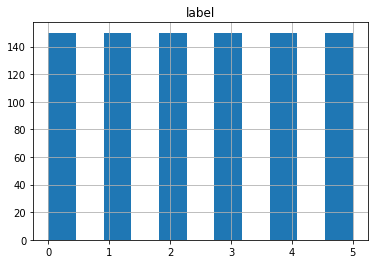

In [205]:
gdf.hist(column="label", bins=11)

In [206]:
gdf.to_file("buffered_points.shp",driver='ESRI Shapefile')

In [127]:
reopened_gdf = gpd.read_file("buffered_points.shp")
reopened_gdf.head()

,canopy,label,tile_name,x,y,geometry
0,0.0,0,028012,1761360.0,1488030.0,POLYGON ((-76.45020728592766 34.81590242273489...
1,0.0,0,028011,1681560.0,1662390.0,POLYGON ((-76.92900325896298 36.48521077384399...
2,0.0,0,028012,1716840.0,1502310.0,POLYGON ((-76.89957784087977 35.02127890428567...
3,0.0,0,028012,1755480.0,1474380.0,POLYGON ((-76.54424306552457 34.70714544743746...
4,0.0,0,028011,1746030.0,1604430.0,POLYGON ((-76.35222097208796 35.86193505990429...


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7ebdeba320>]],
      dtype=object)

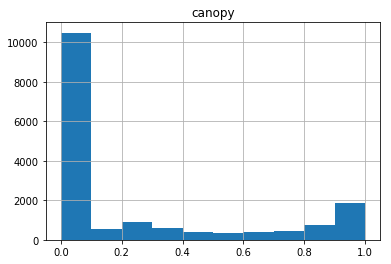

In [146]:
reopened_gdf.hist(column="canopy")

In [130]:
reopened_gdf.crs

{'init': 'epsg:4326'}

In [133]:
reopened_gdf.head()

,canopy,label,tile_name,x,y,geometry
0,0.0,0,028012,1761360.0,1488030.0,POLYGON ((-76.45020728592766 34.81590242273489...
1,0.0,0,028011,1681560.0,1662390.0,POLYGON ((-76.92900325896298 36.48521077384399...
2,0.0,0,028012,1716840.0,1502310.0,POLYGON ((-76.89957784087977 35.02127890428567...
3,0.0,0,028012,1755480.0,1474380.0,POLYGON ((-76.54424306552457 34.70714544743746...
4,0.0,0,028011,1746030.0,1604430.0,POLYGON ((-76.35222097208796 35.86193505990429...


In [144]:
for index, row in df.iterrows():
    print(row['tile_name'])
    print(row['canopy'])
    print(row['geometry'])
    print(row['geometry'].centroid)
    break

028012
0.0
POLYGON ((1761345 1488015, 1761375 1488015, 1761375 1488045, 1761345 1488045, 1761345 1488015))
POINT (1761360 1488030)


In [148]:
pd.cut(reopened_gdf['canopy'], 10).value_counts().sort_index()

(-0.001, 0.1]    10490
(0.1, 0.2]         625
(0.2, 0.3]         827
(0.3, 0.4]         656
(0.4, 0.5]         417
(0.5, 0.6]         312
(0.6, 0.7]         376
(0.7, 0.8]         502
(0.8, 0.9]         779
(0.9, 1.0]        1757
Name: canopy, dtype: int64